# Feature Extraction – Synthetic Data

Approach:
- Create synthetic drilling data
- Add noise of some characteristic to the data
- Use PCA to see if there are any clusters
- Create new, independent synthetic data
- Add same noise in different termporal locations in the signal 
- Use same PCA scores and look for similar clusters

### Create Synthetic Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000
t = np.arange(1, n+1)
trend = 2 + 0.01 * t
seasonal = np.sin(2 * np.pi * t / 12)
cyclical = np.sin(2 * np.pi * t / 60)
irregular = np.random.randn(n)
y = seasonal + cyclical  + trend

In [2]:
# Create random characteristic noise
noise_size = 100
n_noises = 2
noise_frequencies = np.random.randn(n_noises)
sigmas = np.random.randn(n_noises) * 5
mus = np.random.randn(n_noises)
t_noises = []
for _ in range(n_noises):
    t_noise = [int(np.random.uniform(0, n - noise_size))]
    t_noise.append(t_noise[0] + noise_size)
    t_noises.append(range(t_noise[0], t_noise[1]))
noises = [sigma * np.random.rand(noise_size) + mu for sigma, mu in zip(sigmas, mus)]

In [3]:
y_noise = y.copy()
for t_noise, noise in zip(t_noises, noises):
    y_noise[t_noise] = y_noise[t_noise] + noise
        

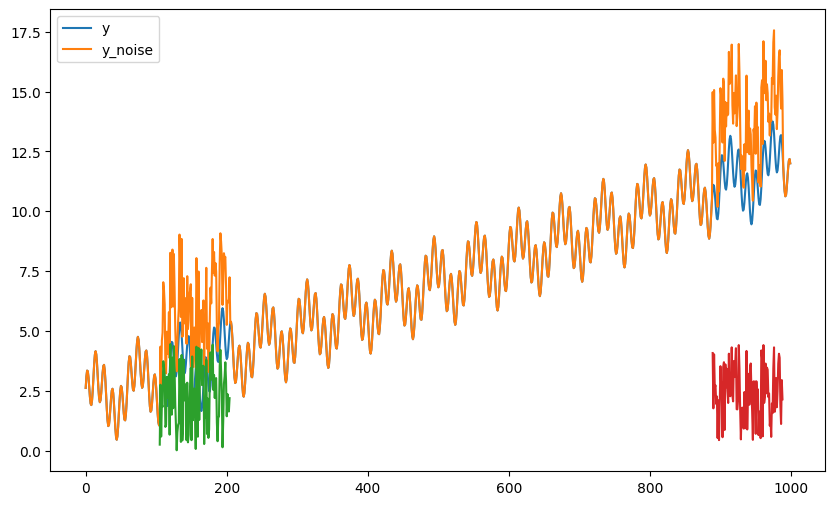

In [4]:
plt.subplots(figsize=(10, 6))
plt.plot(y, label="y")
plt.plot(y_noise, label="y_noise")
#plt.plot(trend, label="trend")
#plt.plot(seasonal, label="seasonal")
#plt.plot(cyclical, label="cyclical")
#plt.plot(irregular, label="irregular")
for t_noise, noise in zip(t_noises, noises):
    plt.plot(t_noise, noise)
plt.legend()

In [5]:
from PyEMD import EMD, Visualisation, EEMD

emd = EMD()
IMFs = emd(y_noise)

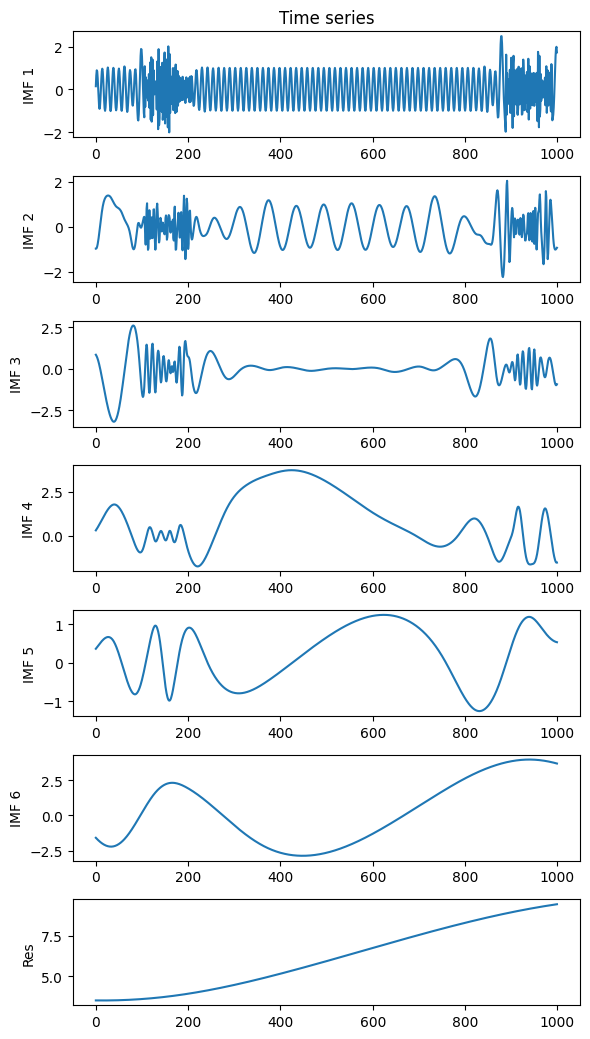

In [6]:
Visualisation(emd).plot_imfs()

In [7]:
# Remove trnd from signal using residual of IMFs
y_noise = y_noise - IMFs[-1]

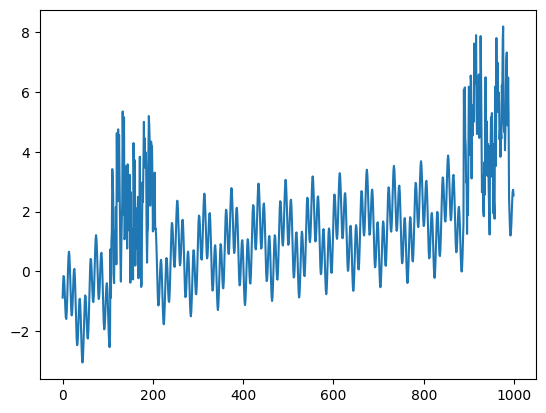

In [8]:
plt.plot(y_noise)

In [9]:
import librosa
import pandas as pd

def get_entropy(data):
    data_nz = data[data != 0]
    return - np.sum(((data_nz**2)*np.log(data_nz**2)))
    
def get_energy(data):  
    N = len(data)
    return np.sum(np.abs(data) ** 2) / N

def get_features(y):
    ft1 = librosa.feature.zero_crossing_rate(y=y)[0]
    ft2 = librosa.feature.spectral_rolloff(y=y)[0]
    ft3 = librosa.feature.spectral_centroid(y=y)[0]
    ft4 = librosa.feature.spectral_contrast(y=y)[0]
    ft5 = librosa.feature.spectral_bandwidth(y=y)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(y), np.std(y), np.max(y), np.median(y), np.min(y), get_energy(y), get_entropy(y)))
    
    ### Spectral Features 
    ft1_trunc = np.hstack((np.mean(ft1), np.std(ft1), np.max(ft1), np.median(ft1), np.min(ft1), get_energy(y), get_entropy(y)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), np.max(ft2), np.median(ft2), np.min(ft2), get_energy(y), get_entropy(y)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), np.max(ft3), np.median(ft3), np.min(ft3), get_energy(y), get_entropy(y)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), np.max(ft4), np.median(ft4), np.min(ft4), get_energy(y), get_entropy(y)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), np.max(ft5), np.median(ft5), np.max(ft5), get_energy(y), get_entropy(y)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc)))

def get_column_names(selected_imfs):
    base = "IMF"
    features = ["mean", "std", "max", "median", "min"]
    others = ['zcr', 'spec_roll_off' , 'spec_centroid', 'spec_contrast', 'spec_bandwidth']

    names = []
    for idx in selected_imfs:
        for feature in features:
            names.append(base + f"_{idx}_" + feature)
        for other in others:
            for feature in features:
                names.append(base + f"_{idx}_" + other + "_" + feature)
    return names

In [10]:
from gtda.time_series import SlidingWindow

# Create windows of y and t
window = SlidingWindow(size=100, stride = 25)

y_windows = window.fit_transform(y_noise)
t_windows = window.fit_transform(t)

In [11]:
import pywt
from PyEMD import EMD, EEMD

all_features = pd.DataFrame()
selected_imfs = [1, 2, 3, 4, 5]
dwt_level = 5

emd = EMD()
eemd = EEMD()

for window in y_windows:
    features = pd.DataFrame()

    # Get features from no decomposed data
    features = pd.concat([features, get_features(window)], axis=0)

    # Get features from wavelet transformed data
    dwts = pywt.wavedec(data=window, wavelet="haar", level=dwt_level)
    for dwt in dwts[1:]:
        features = pd.concat([features, get_features(dwt)])

    # Get features from EMD decomposition of data
    IMFs = emd(window)
    for idx in selected_imfs:
        if idx < len(IMFs):
            imf = IMFs[idx]
        else:
            imf = np.zeros_like(IMFs[0])
        features = pd.concat([features, get_features(imf)])
    
        # Get features from DWT of IMFs
        dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
        for dwt in dwts[1:]:
            features = pd.concat([features, get_features(dwt)])

    # Get features from EEMD decomposition of data
    IMFs = eemd(window)
    for idx in selected_imfs:
        if idx < len(IMFs):
            imf = IMFs[idx]
        else:
            imf = np.zeros_like(IMFs[0])
        features = pd.concat([features, get_features(imf)])
    
        # Get features from DWT of IMFs
        dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
        for dwt in dwts[1:]:
            features = pd.concat([features, get_features(dwt)])
    
    all_features = pd.concat([all_features, features.T])

/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=100
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=4
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=7
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=13
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=25
  return f(*args, *

In [12]:
all_features.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-0.848006,0.964980,1.207968,-0.863992,-3.059645,1.650300,-190.148074,0.004883,0.0,0.004883,...,0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.000000
0,-0.485091,1.565274,4.754047,-0.764205,-3.059645,2.685395,-455.424319,0.005859,0.0,0.005859,...,0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.000000
0,0.516898,1.861390,5.352701,0.261537,-2.546338,3.731955,-799.041818,0.006348,0.0,0.006348,...,0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.000000
0,1.023162,1.816356,5.352701,0.874454,-2.546338,4.346011,-966.842620,0.009277,0.0,0.009277,...,0.986929,0.000165,0.071119,2288.210226,0.0,2288.210226,2288.210226,2288.210226,0.000165,0.071119
0,1.927178,1.836044,5.352701,1.839378,-2.546338,7.085075,-1768.560812,0.008301,0.0,0.008301,...,0.814273,0.000043,0.021302,1928.899318,0.0,1928.899318,1928.899318,1928.899318,0.000043,0.021302


In [13]:
from sklearn.decomposition import PCA

# Caluclate principal components
pca = PCA()
pca.fit(all_features)
scores = pca.fit_transform(all_features)
loadings = pca.components_.T

In [14]:
# Color label the socres according to if they are a part of the noise or not
colors = []
for t_window in t_windows:
    is_in = False
    for t_noise in t_noises:
        if np.any(np.isin(t_window, t_noise)):
            is_in = True
            break
    if is_in:
        colors.append("red")
    else:
        colors.append("blue")

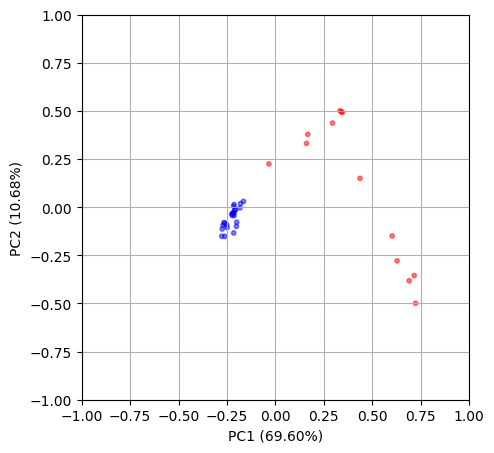

In [15]:
xs = scores[:, 0]
ys = scores[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, s=10, alpha=0.5, c=colors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

plt.grid()
plt.show()

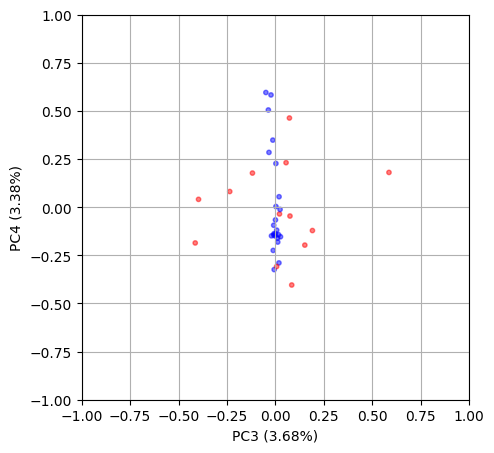

In [16]:
xs = scores[:, 2]
ys = scores[:, 3]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, s=10, alpha=0.5, c=colors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
plt.ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.2f}%)")

plt.grid()
plt.show()

### Same process for new data

In [17]:
n = 1000
t = np.arange(1, n+1)
trend = 2 + 0.01 * t
seasonal = np.sin(2 * np.pi * t / 12)
cyclical = np.sin(2 * np.pi * t / 60)
irregular = np.random.randn(n)
y_new = seasonal + cyclical  + trend

In [28]:
y_new_noise = y_new.copy()

t_new_noises = []
for _ in range(n_noises):
    y_new_noise = [int(np.random.uniform(0, n - noise_size))]
    y_new_noise.append(y_new_noise[0] + noise_size)
    y_new_noise.append(range(y_new_noise[0], y_new_noise[1]))

for t_noise, noise in zip(y_new_noise, noises):
    y_new_noise[t_noise] = y_new_noise[t_noise] + noise

IndexError: list index out of range

In [24]:
# Create windows of y and t
window = SlidingWindow(size=100, stride = 25)

y_windows = window.fit_transform(y_noise)
t_windows = window.fit_transform(t)

In [25]:
all_features_new = pd.DataFrame()
selected_imfs = [1, 2, 3, 4, 5]
dwt_level = 5

emd = EMD()
eemd = EEMD()

for window in y_windows:
    features = pd.DataFrame()

    # Get features from no decomposed data
    features = pd.concat([features, get_features(window)], axis=0)

    # Get features from wavelet transformed data
    dwts = pywt.wavedec(data=window, wavelet="haar", level=dwt_level)
    for dwt in dwts[1:]:
        features = pd.concat([features, get_features(dwt)])

    # Get features from EMD decomposition of data
    IMFs = emd(window)
    for idx in selected_imfs:
        if idx < len(IMFs):
            imf = IMFs[idx]
        else:
            imf = np.zeros_like(IMFs[0])
        features = pd.concat([features, get_features(imf)])
    
        # Get features from DWT of IMFs
        dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
        for dwt in dwts[1:]:
            features = pd.concat([features, get_features(dwt)])

    # Get features from EEMD decomposition of data
    IMFs = eemd(window)
    for idx in selected_imfs:
        if idx < len(IMFs):
            imf = IMFs[idx]
        else:
            imf = np.zeros_like(IMFs[0])
        features = pd.concat([features, get_features(imf)])
    
        # Get features from DWT of IMFs
        dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
        for dwt in dwts[1:]:
            features = pd.concat([features, get_features(dwt)])
    
    all_features_new = pd.concat([all_features, features.T])

/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=100
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=4
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=7
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=13
  return f(*args, **kwargs)
/Users/emilhaugstvedt/mambaforge/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=25
  return f(*args, *

In [21]:
# Compute scores using same PCA as earlier
scores = pca.fit_transform(all_features_new)

In [26]:
# Color label the socres according to if they are a part of the noise or not
colors = []
for t_window in t_windows:
    is_in = False
    for t_noise in t_noises:
        if np.any(np.isin(t_window, t_noise)):
            is_in = True
            break
    if is_in:
        colors.append("red")
    else:
        colors.append("blue")

ValueError: 'c' argument has 37 elements, which is inconsistent with 'x' and 'y' with size 38.

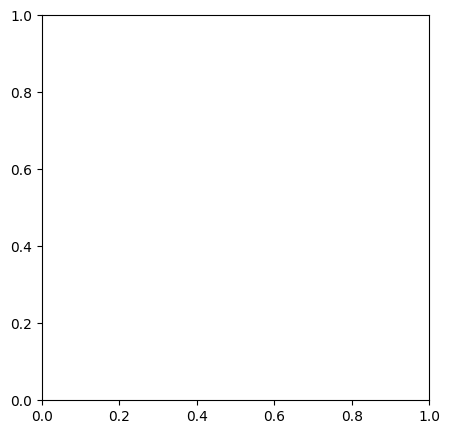

In [27]:
xs = scores[:, 0]
ys = scores[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex,ys * scaley, s=10, alpha=0.5, c=colors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

plt.grid()
plt.show()